In [2]:
import torch
import torch.nn as nn
from torchgeo.models import resnet50, ResNet50_Weights
from torchsummary import summary
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from torch import from_numpy
from loader import loader
import numpy as np
import h5py
import os
import sys
# import local modules
from siamese_resnet50_unet import SiameseUNetWithResnet50Encoder
from data_loading import FireDataset
from train_model import train_model
from torchgeo.models import resnet50, ResNet50_Weights

import gc
import torch
gc.collect()
torch.cuda.empty_cache()

!nvidia-smi
    

Thu Jun 15 06:50:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   33C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Provide your hdf5_file and fold values
train_dataset = FireDataset(['datasets/train_eval.hdf5'], [0, 1, 2, 3])
#train_dataset = FireDataset(['datasets/california_1.hdf5', 'datasets/california_0.hdf5', 'datasets/california_3.hdf5', 'datasets/california_2.hdf5', 'datasets/california_4.hdf5'], None)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)

valid_dataset = FireDataset(['datasets/train_eval.hdf5'], [4])
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=2)

In [4]:
# import time
# for i, (pre_imgs, post_imgs, labels) in enumerate(train_dataloader):
#             #print(labels.shape)
#             plt.imshow(labels.squeeze(), cmap='gray')
#             plt.show()
#             time.sleep(1)

In [5]:
# post = []
# pre = []
# masks = []
# names = []

# with h5py.File('datasets/california_1.hdf5', "r") as f:
#     for uuid, values in f.items():
#         post.append(values["post_fire"][...])
#         pre.append(values["pre_fire"][...])
#         masks.append(values["mask"][...])
#         names.append(uuid)

In [6]:
import torch.nn.functional as F

class IoUBCELoss(nn.Module):
    def __init__(self, eps=1e-6, iou_weight=0.5, bce_weight=0.5):
        super(IoUBCELoss, self).__init__()
        self.eps = eps
        self.iou_weight = iou_weight
        self.bce_weight = bce_weight

    def forward(self, preds, target):
        
        # Compute BCEWithLogitsLoss
        bce_loss = F.binary_cross_entropy_with_logits(preds, target)
        # Apply sigmoid to the predictions
        preds = torch.sigmoid(preds)

        # Calculate intersection and union
        intersection = (preds * target).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection

        # Compute IoU
        iou = (intersection + self.eps) / (union + self.eps)

        # Calculate the combined loss
        combined_loss = self.iou_weight * (1 - iou.mean()) + self.bce_weight * bce_loss

        # Visualization
        self.visualize(preds.detach().cpu(), target.detach().cpu(), intersection.detach().cpu())

        return combined_loss

    def visualize(self, pred, target, intersection):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))

        axs[0].imshow(pred[0, 0, :, :], cmap='gray')
        axs[0].set_title('Prediction')

        axs[1].imshow(target[0, 0, :, :], cmap='gray')
        axs[1].set_title('Ground Truth')

        axs[2].imshow((pred[0, 0, :, :] * target[0, 0, :, :]).numpy(), cmap='gray')
        axs[2].set_title('Intersection')

        plt.show()
   

In [7]:
model = SiameseUNetWithResnet50Encoder()

# optional freeze
freeze = True

if freeze:
     # Freeze the parameters of the ResNet layers
    for param in model.input_block.parameters():
        param.requires_grad = False
    for param in model.input_pool.parameters():
        param.requires_grad = False
    for block in model.down_blocks:
        for param in block.parameters():
            param.requires_grad = False

# begin training
criterion = nn.BCEWithLogitsLoss()
#criterion = IoUBCELoss(iou_weight=0, bce_weight=1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


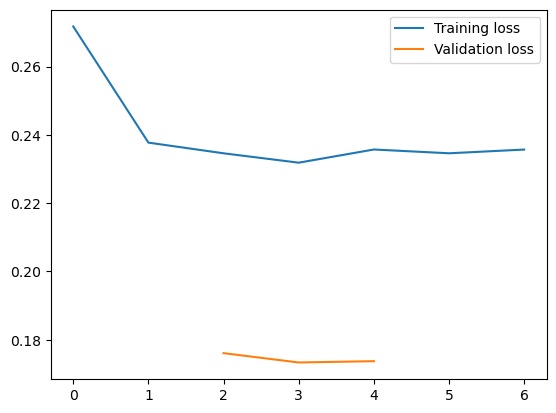

Epoch 7/24
----------
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [ ]:
final_model = train_model(model, train_dataloader, valid_dataloader, criterion, optimizer, scheduler, num_epochs=25)

In [ ]:
torch.save(final_model.state_dict(), 'final_model.pt')